<a href="https://colab.research.google.com/github/Dieto-cmd/Churn-Predictor/blob/main/project_core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Analysis and Pattern Recognition Project Raport


*   Author: Paweł Urban
*   AGH University of Science And Technology
*   Elektronika i Telekomunikacja

##*Prerequisites*
I was given a data regarding clients of a certain company, and information if they prolonged their contract or not. I was also given a data about some other clients but without the information if they had prolonged the contract. My task is to choose and train a Classifier that will predict whether or not the clients will porlong contract based on the given data. The model will be graded based on the roc_auc score.



#Imports



*   importing necessary libriaries



---



In [ ]:
import numpy as np
import google.colab
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.model_selection import GridSearchCV

# Drive mounting


---



In [ ]:
google.colab.drive.mount('/content/drive/')

path_to_folder = "/content/drive/MyDrive/ADiRW/Projekt"

%cd $path_to_folder

! ls

Mounted at /content/drive/
/content/drive/MyDrive/ADiRW/Projekt
dataset.csv	    queries.csv		  test_predictions_Nikakda.csv
project_core.ipynb  test_predictions.csv


# Data loading

Dataset entries are described [here](https://www.kaggle.com/datasets/blastchar/telco-customer-churn).

Dataset - data where I know if a client prolonged a contract

Churn column - if equal to 1 client prolonged the contract, if 0 did not prolong


---



In [ ]:
dataset = pd.read_csv('./dataset.csv')
display(dataset.head(5))

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0.0,Yes,Yes,72.0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),25.20,1787.35,0
1,Male,0.0,No,No,40.0,Yes,No,Fiber optic,No,Yes,No,Yes,No,Yes,One year,Yes,Credit card (automatic),89.60,3488.15,0
2,Male,0.0,Yes,Yes,40.0,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,One year,No,Mailed check,60.30,2448.5,0
3,Male,0.0,Yes,Yes,58.0,Yes,Yes,Fiber optic,No,No,Yes,Yes,No,Yes,Two year,No,Bank transfer (automatic),94.35,5563.65,0
4,Male,0.0,Yes,Yes,44.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),20.00,860.85,0


Queries - data where I do not know if a client prolonged a contract

In [ ]:
queries = pd.read_csv('./queries.csv')
display(queries.head(5))

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Male,0.0,No,No,45.0,No,No phone service,DSL,Yes,NaN,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
1,Male,0.0,Yes,Yes,13.0,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,49.95,587.45
2,Male,0.0,No,Yes,71.0,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Two year,No,Bank transfer (automatic),106.70,7382.25
3,Female,0.0,No,No,30.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),55.30,1530.6
4,Female,1.0,Yes,No,71.0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,No,Two year,Yes,Credit card (automatic),96.35,6766.95


# Pre-processing
Firstly I need to modify the data so it can be fed into the model


---



##Handling null *values*


---

As I can see our dataset contains undefined values

In [ ]:
dataset.isnull().sum()

,0
gender,26
SeniorCitizen,29
Partner,27
Dependents,27
tenure,36
PhoneService,23
MultipleLines,22
InternetService,27
OnlineSecurity,37
OnlineBackup,30


**I have a few data types in our dataset. In order to eliminate null values I need to treat each of them differently**

*Categorical data* - data where there is at least 3 types of an answer e.g value of 'InternetService' column could be: 'DSL', 'Fiber Optic', 'No'

In this situation I create a new category called 'X' and replace null values with it

In [ ]:
dataset_processed = dataset.copy()
categorical_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'Contract','PaymentMethod']
dataset_processed[categorical_columns] = dataset_processed[categorical_columns].fillna('X')

*Numeric data* - data represented by numbers

To fill null values I use k nearest neighbors technique

In [ ]:
imputer = KNNImputer(n_neighbors= 5)

dataset_processed['tenure'] = imputer.fit_transform(dataset[['tenure']])
dataset_processed['MonthlyCharges'] = imputer.fit_transform(dataset[['MonthlyCharges']])

#There were problems with using KNNImputer() to 'TotalCharges' column because it is stored as strings
#so I took a mean of every value in 'TotalCharges' and replaced nulls with it
dataset_processed['TotalCharges'] = pd.to_numeric(dataset_processed['TotalCharges'], errors='coerce')
dataset_processed['TotalCharges'] = dataset_processed['TotalCharges'].fillna(dataset_processed['TotalCharges'].mean())

*Binary data * - data where there are only 2 possible answers

Here I look at the distribution of data e.g in 'gender' how much percentage of a whole set does Males occupy, and based on that distribution I assign Male/Female to the null values

In [ ]:
prob_male = dataset_processed['gender'].value_counts(normalize = True).get('Male',0)
prob_female = dataset_processed['gender'].value_counts(normalize = True).get('Female',0)
dataset_processed['gender'] = dataset_processed['gender'].fillna(np.random.choice(['Male', 'Female'], p=[prob_male, prob_female]))

prob_yes = dataset_processed['PhoneService'].value_counts(normalize = True).get('Yes',0)
prob_no = dataset_processed['PhoneService'].value_counts(normalize = True).get('No',0)
dataset_processed['PhoneService'] = dataset_processed['PhoneService'].fillna(np.random.choice(['Yes', 'No'], p=[prob_yes, prob_no]))

prob_yes = dataset_processed['PaperlessBilling'].value_counts(normalize = True).get('Yes',0)
prob_no = dataset_processed['PaperlessBilling'].value_counts(normalize = True).get('No',0)
dataset_processed['PaperlessBilling'] = dataset_processed['PaperlessBilling'].fillna(np.random.choice(['Yes', 'No'], p=[prob_yes, prob_no]))

prob_yes = dataset_processed['Partner'].value_counts(normalize = True).get('Yes',0)
prob_no = dataset_processed['Partner'].value_counts(normalize = True).get('No',0)
dataset_processed['Partner'] = dataset_processed['Partner'].fillna(np.random.choice(['Yes', 'No'], p=[prob_yes, prob_no]))

prob_yes = dataset_processed['Dependents'].value_counts(normalize = True).get('Yes',0)
prob_no = dataset_processed['Dependents'].value_counts(normalize = True).get('No',0)
dataset_processed['Dependents'] = dataset_processed['Dependents'].fillna(np.random.choice(['Yes', 'No'], p=[prob_yes, prob_no]))

prob_yes = dataset_processed['SeniorCitizen'].value_counts(normalize = True).get(1,0)
prob_no = dataset_processed['SeniorCitizen'].value_counts(normalize = True).get(0,0)
dataset_processed['SeniorCitizen'] = dataset_processed['SeniorCitizen'].fillna(np.random.choice([1, 0], p=[prob_yes, prob_no]))
dataset_processed.isnull().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


##Mapping boolean and categorical features to numeric data, normalising the numeric data
The model is able to operate only on numeric data, so I need to transform categorical and binary columns to numeric values



---



When it comes to binary data I can change its values to 0 and 1 e.g in 'gender' Female will be mapped to 0 and Male to 1

In [ ]:
dataset_processed['gender'] = dataset_processed['gender'].map({'Female': 0, 'Male': 1})
dataset_processed['PhoneService'] = dataset_processed['PhoneService'].map({'No': 0, 'Yes': 1})
dataset_processed['PaperlessBilling'] = dataset_processed['PaperlessBilling'].map({'No': 0, 'Yes': 1})
dataset_processed['Partner'] = dataset_processed['Partner'].map({'No': 0, 'Yes': 1})
dataset_processed['Dependents'] = dataset_processed['Dependents'].map({'No': 0, 'Yes': 1})

To map categorical data to numeric data I could also map it to certain values e.g 0, 0.5, 1 but it introduces false classification 0 < 0.5 < 1. So instead I will use pd.get_dummies() function which creates new columns that represent each possible answer for a certain data.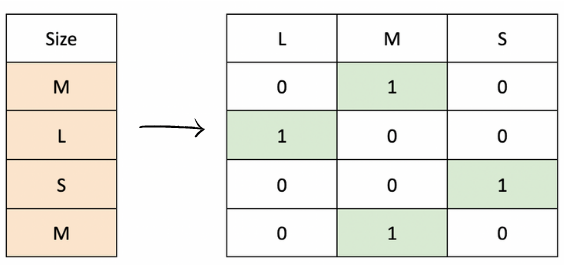

In [ ]:
dataset_processed = pd.get_dummies(dataset_processed, columns=['MultipleLines', 'InternetService', 'OnlineSecurity',
                                                               'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                                               'StreamingTV', 'StreamingMovies', 'Contract',
                                                               'PaymentMethod'],dtype=int )

For numeric data I need to normalize it. After normalizing the values of the data, it will range from 0 to 1. It is done beaceuse otherwise the model could think that the data with higher values e.g 'TotalCharges' is more important than data with smaller values e.g 'tenure'


In [ ]:
dataset_processed['tenure'] = (dataset_processed["tenure"] - dataset_processed["tenure"].min()) / (dataset_processed["tenure"].max() - dataset_processed["tenure"].min())
dataset_processed['MonthlyCharges'] = (dataset_processed["MonthlyCharges"] - dataset_processed["MonthlyCharges"].min()) / (dataset_processed["MonthlyCharges"].max() - dataset_processed["MonthlyCharges"].min())


dataset_processed['TotalCharges'] = (dataset_processed["TotalCharges"] - dataset_processed["TotalCharges"].min()) / (dataset_processed["TotalCharges"].max() - dataset_processed["TotalCharges"].min())




Lastly I save 'Churn' column in a new variable labels

In [ ]:
labels = dataset_processed['Churn'].copy()
dataset_processed = dataset_processed.drop('Churn', axis=1)
np.shape(dataset_processed)

(5634, 50)

#Visualisation
Now I need to examine which data that I have is helpful and which is not.


---


Here I can see that when 'MultipleLines' variable changes the Churn probability stays almost the same. Therefore it is not a useful data

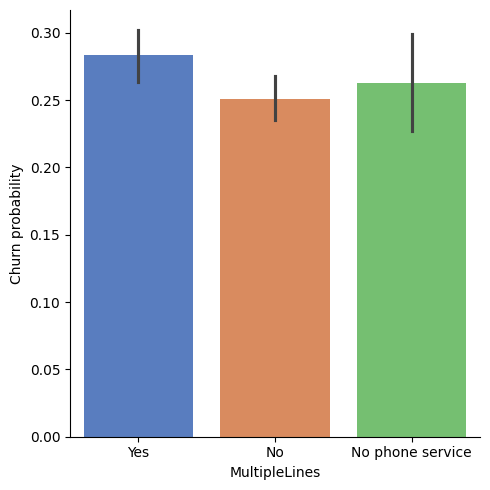

In [ ]:
g  = sns.catplot(x="MultipleLines", y="Churn", data=dataset, kind="bar", palette="muted", hue="MultipleLines", legend=False)
g = g.set_ylabels("Churn probability")
plt.show()

Gender category is also not of much use for us

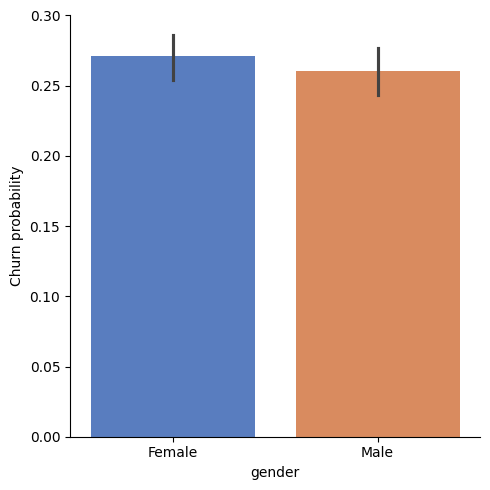

In [ ]:
g  = sns.catplot(x="gender", y="Churn", data=dataset, kind="bar", palette="muted", hue="gender", legend=False)
g = g.set_ylabels("Churn probability")
plt.show()

I can see that depending on the 'SeniorCitizen' category the Churn probability changes a lot. This is a very informative data.

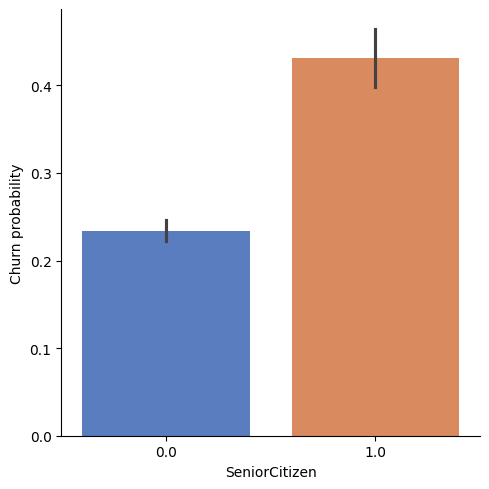

In [ ]:
g  = sns.catplot(x="SeniorCitizen", y="Churn", data=dataset, kind="bar", palette="muted", hue="SeniorCitizen", legend=False)
g = g.set_ylabels("Churn probability")
plt.show()

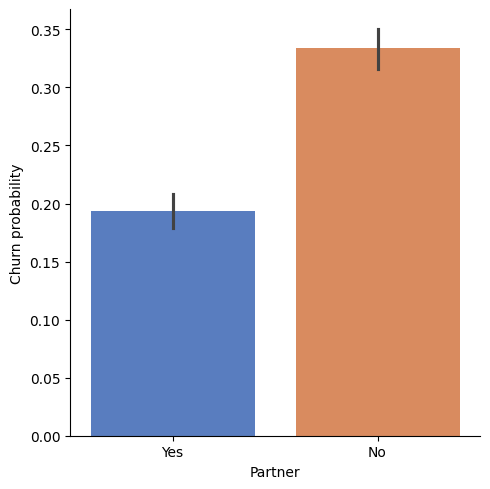

In [ ]:
g  = sns.catplot(x="Partner", y="Churn", data=dataset, kind="bar", palette="muted", hue="Partner", legend=False)
g = g.set_ylabels("Churn probability")
plt.show()

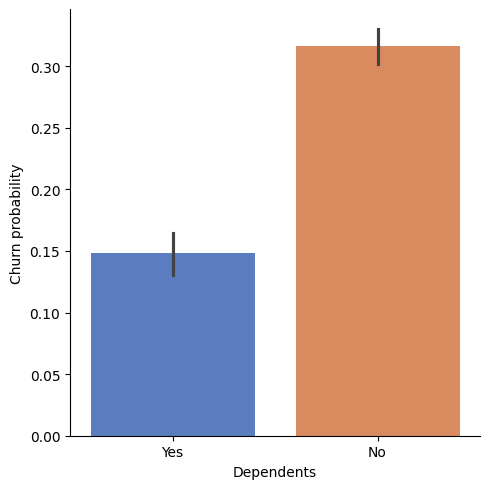

In [ ]:
g  = sns.catplot(x="Dependents", y="Churn", data=dataset, kind="bar", palette="muted", hue="Dependents", legend=False)
g = g.set_ylabels("Churn probability")
plt.show()

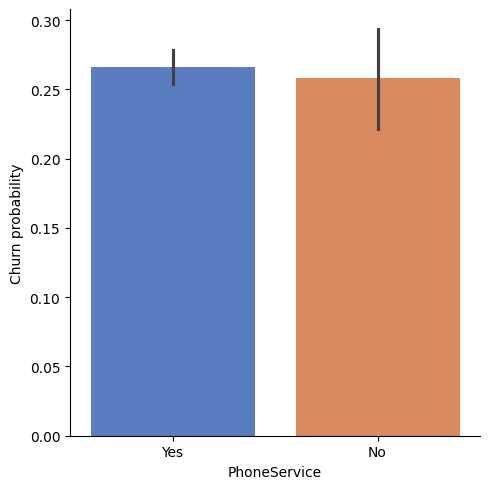

In [ ]:
g  = sns.catplot(x="PhoneService", y="Churn", data=dataset, kind="bar", palette="muted", hue="PhoneService", legend=False)
g = g.set_ylabels("Churn probability")
plt.show()

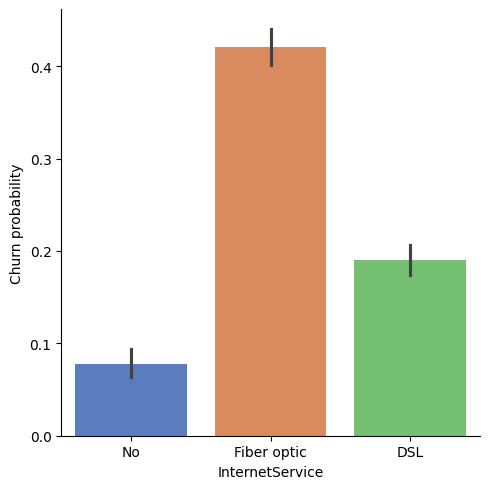

In [ ]:
g  = sns.catplot(x="InternetService", y="Churn", data=dataset, kind="bar", palette="muted", hue="InternetService", legend=False)
g = g.set_ylabels("Churn probability")
plt.show()

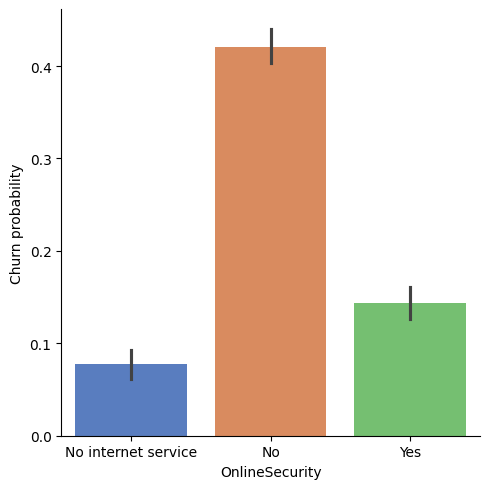

In [ ]:
g  = sns.catplot(x="OnlineSecurity", y="Churn", data=dataset, kind="bar", palette="muted", hue="OnlineSecurity", legend=False)
g = g.set_ylabels("Churn probability")
plt.show()

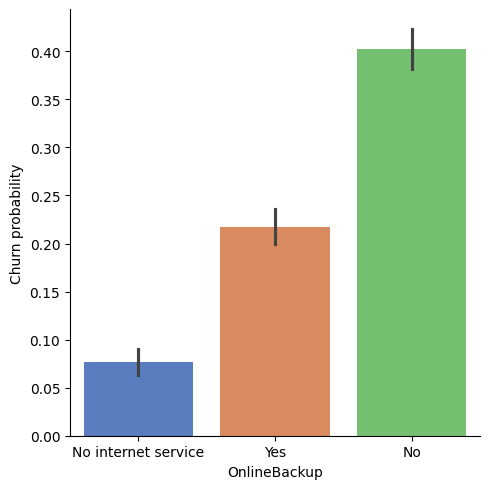

In [ ]:
g  = sns.catplot(x="OnlineBackup", y="Churn", data=dataset, kind="bar", palette="muted", hue="OnlineBackup", legend=False)
g = g.set_ylabels("Churn probability")
plt.show()

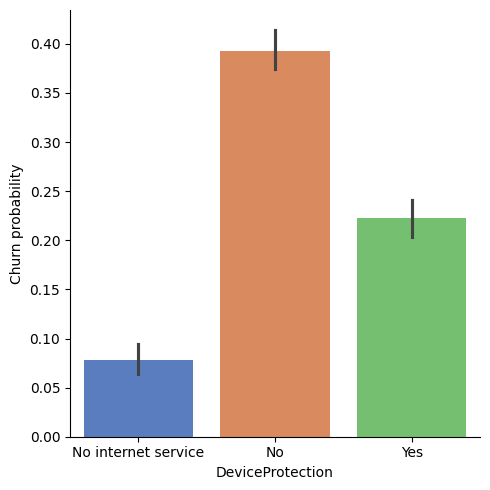

In [ ]:
g  = sns.catplot(x="DeviceProtection", y="Churn", data=dataset, kind="bar", palette="muted", hue="DeviceProtection", legend=False)
g = g.set_ylabels("Churn probability")
plt.show()

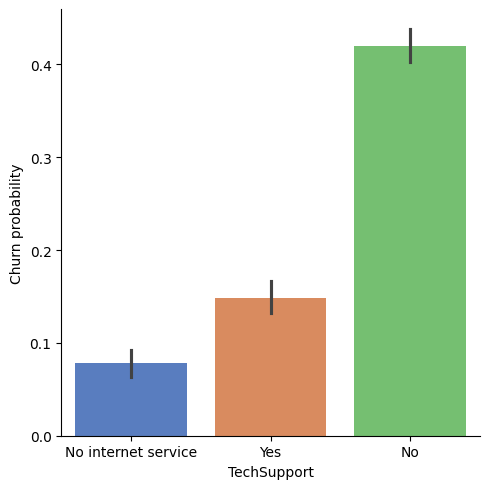

In [ ]:
g  = sns.catplot(x="TechSupport", y="Churn", data=dataset, kind="bar", palette="muted", hue="TechSupport", legend=False)
g = g.set_ylabels("Churn probability")
plt.show()

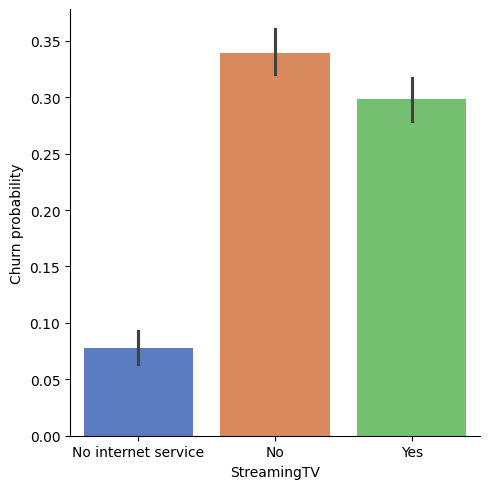

In [ ]:
g  = sns.catplot(x="StreamingTV", y="Churn", data=dataset, kind="bar", palette="muted", hue="StreamingTV", legend=False)
g = g.set_ylabels("Churn probability")
plt.show()

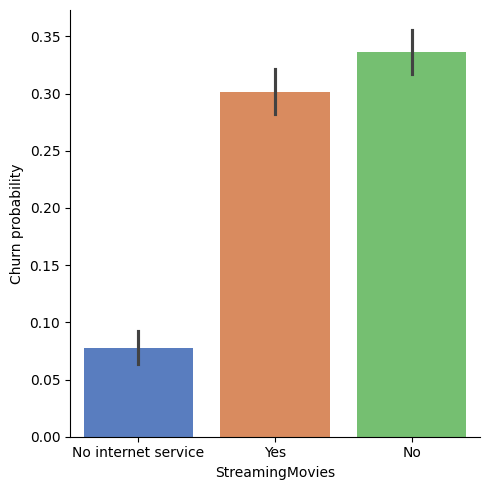

In [ ]:
g  = sns.catplot(x="StreamingMovies", y="Churn", data=dataset, kind="bar", palette="muted", hue="StreamingMovies", legend=False)
g = g.set_ylabels("Churn probability")
plt.show()

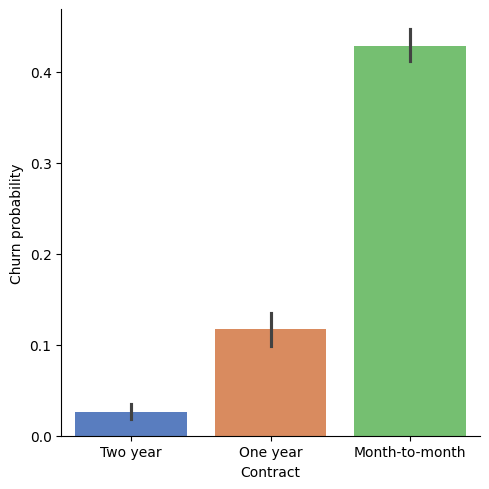

In [ ]:
g  = sns.catplot(x="Contract", y="Churn", data=dataset, kind="bar", palette="muted", hue="Contract", legend=False)
g = g.set_ylabels("Churn probability")
plt.show()

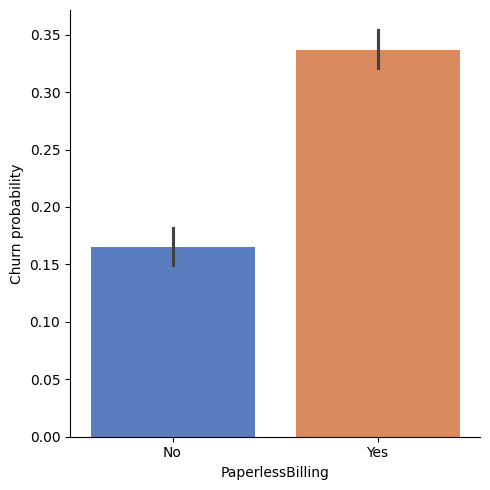

In [ ]:
g  = sns.catplot(x="PaperlessBilling", y="Churn", data=dataset, kind="bar", palette="muted", hue="PaperlessBilling", legend=False)
g = g.set_ylabels("Churn probability")
plt.show()

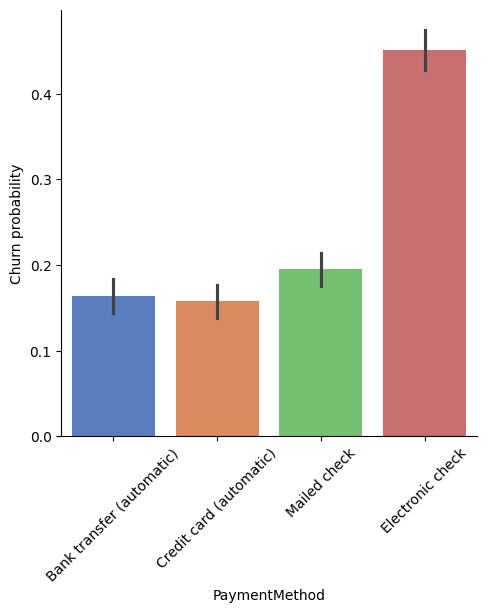

In [ ]:
g  = sns.catplot(x="PaymentMethod", y="Churn", data=dataset, kind="bar", palette="muted", hue="PaymentMethod", legend=False)
g = g.set_ylabels("Churn probability")
g.set_xticklabels(rotation=45)
plt.show()

Here I am examining the numeric data

To do that I generate 3 plots, one for all the clients, one for clients that prolonged the contract, and one for clients that did not prolong

Looking at the 'tenure' plots I can see a big difference in the shape of 'Churn' plot compared to 'All' plot. This indicates 'tenure' is a useful data

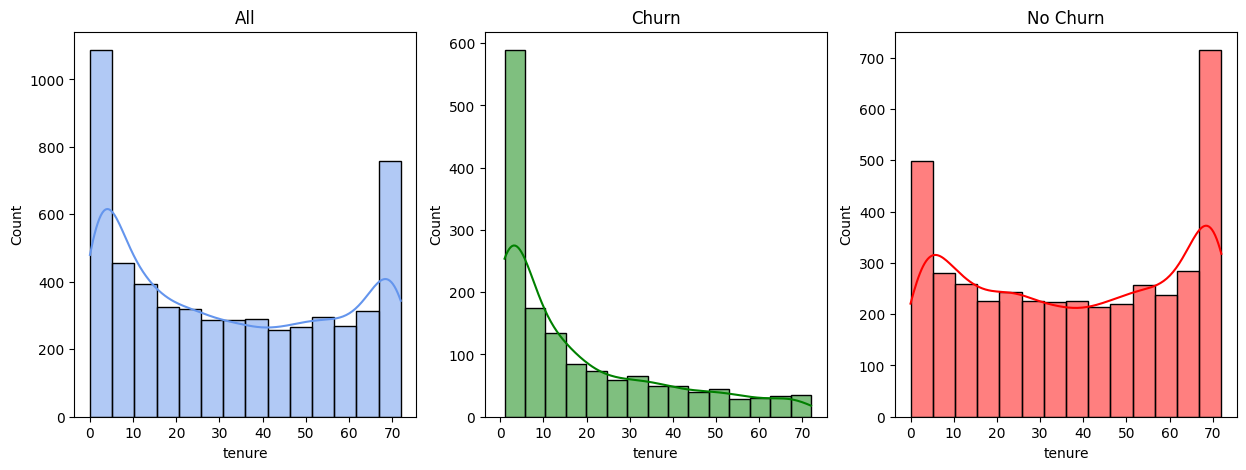

In [ ]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
axes[0].set_title('All')
sns.histplot(dataset['tenure'], kde=True, ax=axes[0], color='cornflowerblue')

axes[1].set_title('Churn')
sns.histplot(dataset[dataset['Churn'] == 1]['tenure'], kde=True, ax=axes[1], color='g')

axes[2].set_title('No Churn')
sns.histplot(dataset[dataset['Churn'] == 0]['tenure'], kde=True, ax=axes[2], color='r')

fig.show()

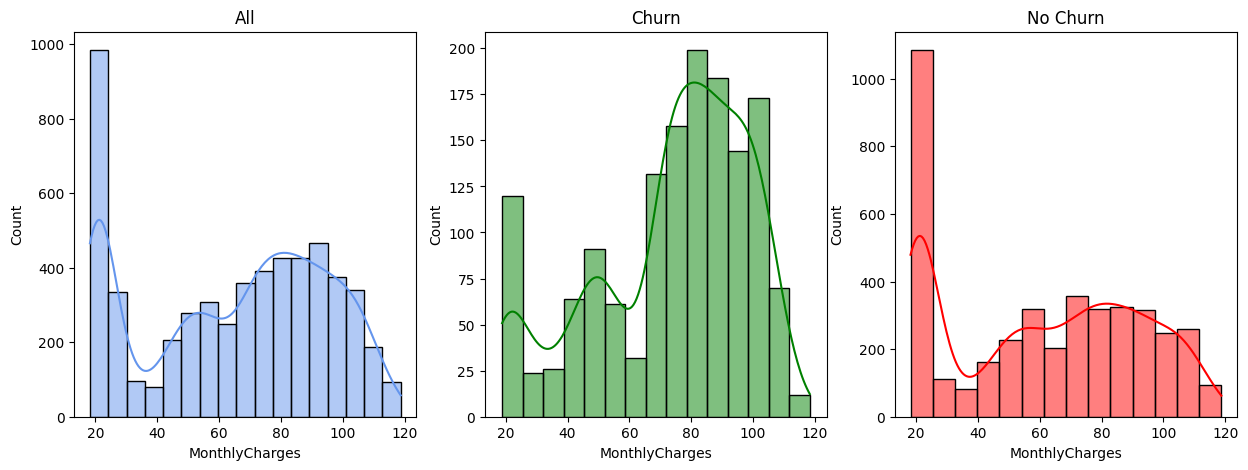

In [ ]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
axes[0].set_title('All')
sns.histplot(dataset['MonthlyCharges'], kde=True, ax=axes[0], color='cornflowerblue')

axes[1].set_title('Churn')
sns.histplot(dataset[dataset['Churn'] == 1]['MonthlyCharges'], kde=True, ax=axes[1], color='g')

axes[2].set_title('No Churn')
sns.histplot(dataset[dataset['Churn'] == 0]['MonthlyCharges'], kde=True, ax=axes[2], color='r')

fig.show()

'TotalCharges' plots are of very similiar shape, thus it is not beneficial to include them.

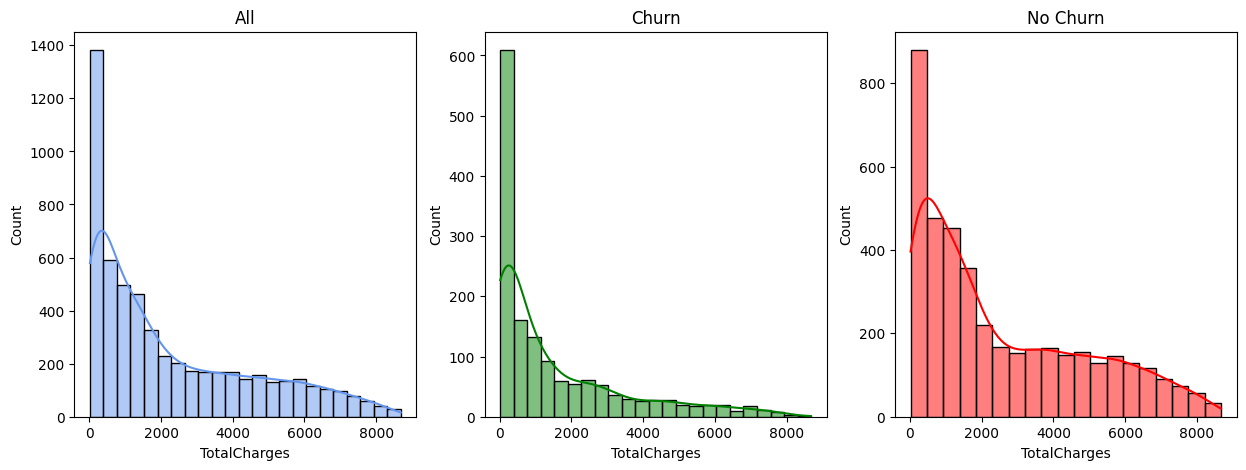

In [ ]:
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')
#TotalCharges column needs to be a float but it's a string so I convert it with pd.to_numeric()
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
axes[0].set_title('All')
sns.histplot(dataset['TotalCharges'], kde=True, ax=axes[0], color='cornflowerblue')

axes[1].set_title('Churn')
sns.histplot(dataset[dataset['Churn'] == 1]['TotalCharges'], kde=True, ax=axes[1], color='g')

axes[2].set_title('No Churn')
sns.histplot(dataset[dataset['Churn'] == 0]['TotalCharges'], kde=True, ax=axes[2], color='r')

fig.show()

#Feature Extraction
Now I exclude the data that I decided is not usefull.


---


To demonstrate the effect it has on the data I perform Principal Component Analisys. The graph shows how 'good' the data is. If the yellow and purple dots are visibly separated that means based on the data it is easy to predict the answers. If the dots are cluttered it is hard to determine the outcome.

Text(0.5, 0, 'Principal Component 1(Before feature Extraction)')

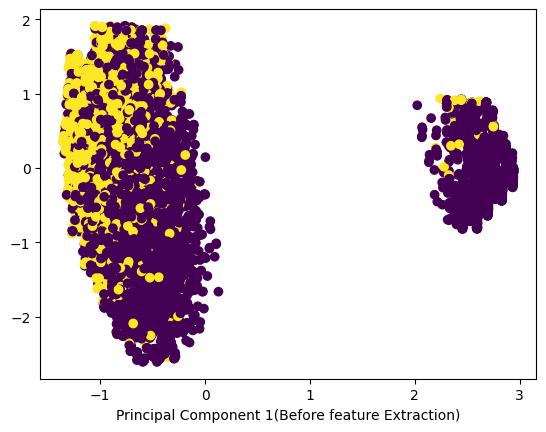

In [ ]:
PCA_2D = PCA(n_components=2).fit_transform(dataset_processed)
plt.scatter(PCA_2D[:, 0], PCA_2D[:, 1], c=labels, cmap='viridis')
plt.xlabel('Principal Component 1(Before feature Extraction)')

I can see that after the data extraction yellow dots are a bit more cluttered in the left up corner which means that I indeed was right about droping the data

Text(0.5, 0, 'Principal Component 1(After Feature Extraction)')

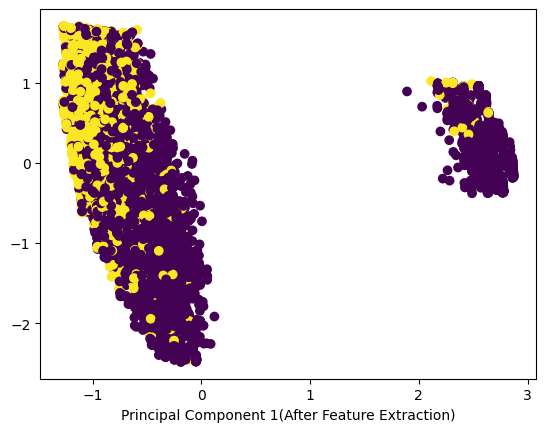

In [ ]:
dataset_processed = dataset_processed.drop(['TotalCharges','PhoneService','MultipleLines_No','MultipleLines_No phone service',
                                            'MultipleLines_X','MultipleLines_Yes','gender'], axis=1)
PCA_2D = PCA(n_components=2).fit_transform(dataset_processed)
plt.scatter(PCA_2D[:, 0], PCA_2D[:, 1], c=labels, cmap='viridis')
plt.xlabel('Principal Component 1(After Feature Extraction)')

#Choosing and testing a classifier

##Generating train and test data
I need to split the data that I have. 80% of the dataset will be for training the model and 20% for testing the model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset_processed, labels, test_size=0.2, random_state=23)

##Testing different Classifiers
Here I am testing a few Classifiers with default hyperparameters to see how they perform


---


The 3 best Classifiers based on this test are


*   SVM(Support Vector Machine)
*   Ada Boost
*   Neural Net


In [ ]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=100, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]
for name, clf in zip(names, classifiers):
    print(name + " score: ", clf.fit(X_train, y_train).score(X_test, y_test))

Nearest Neighbors score:  0.7364685004436557
Linear SVM score:  0.8039041703637977
RBF SVM score:  0.7861579414374446
Decision Tree score:  0.7914818101153505
Random Forest score:  0.7551020408163265
Neural Net score:  0.8110026619343389
AdaBoost score:  0.8145519077196096
Naive Bayes score:  0.6858917480035492
QDA score:  0.38864241348713396


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


##Choosing Hyperparameters
Now I will look for the best hyper-parameters for 3 Classifiers chosen in the previous step.

I will use GridSearchCV() function which also performs cross-validation testing. That ensures that the model I train is good not only at the testing dataset but good in general

The models will be judged based on the roc_auc score


---


###*Ada Boost* :

In [ ]:
AdaBst = AdaBoostClassifier(random_state=42,estimator = DecisionTreeClassifier(random_state=42,max_depth=1))
params = {
    'n_estimators': [1, 5, 10, 20, 50, 100, 200, 500],
    'learning_rate': [0.0001, 0.5, 1, 2, 5]
}
grid_search = GridSearchCV(estimator=AdaBst,param_grid = params, verbose=3, scoring='roc_auc', return_train_score=False, cv=5)
grid_search.fit(dataset_processed, labels)
print("Best score:", grid_search.best_score_)
print("Best hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END learning_rate=0.0001, n_estimators=1;, score=0.500 total time=   0.0s
[CV 2/5] END learning_rate=0.0001, n_estimators=1;, score=0.500 total time=   0.0s
[CV 3/5] END learning_rate=0.0001, n_estimators=1;, score=0.500 total time=   0.0s
[CV 4/5] END learning_rate=0.0001, n_estimators=1;, score=0.500 total time=   0.0s
[CV 5/5] END learning_rate=0.0001, n_estimators=1;, score=0.500 total time=   0.0s
[CV 1/5] END learning_rate=0.0001, n_estimators=5;, score=0.500 total time=   0.1s
[CV 2/5] END learning_rate=0.0001, n_estimators=5;, score=0.500 total time=   0.1s
[CV 3/5] END learning_rate=0.0001, n_estimators=5;, score=0.500 total time=   0.1s
[CV 4/5] END learning_rate=0.0001, n_estimators=5;, score=0.500 total time=   0.1s
[CV 5/5] END learning_rate=0.0001, n_estimators=5;, score=0.500 total time=   0.1s
[CV 1/5] END learning_rate=0.0001, n_estimators=10;, score=0.500 total time=   0.1s
[CV 2/5] END learning_ra

###*Neural Net*:

In [ ]:
mlp = MLPClassifier(random_state=42,max_iter=600)
params ={'solver': ['adam','sgd'],
         'hidden_layer_sizes' : [[200,],[200,50],[200,150],[200,150,50]],
         'activation': ['relu','identity', 'logistic']}
grid_search = GridSearchCV(estimator=mlp,param_grid = params, verbose=3, scoring='roc_auc', return_train_score=False, cv=5)
grid_search.fit(dataset_processed, labels)
print("Best score:", grid_search.best_score_)
print("Best hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END activation=relu, hidden_layer_sizes=[200], solver=adam;, score=0.790 total time=  30.9s
[CV 2/5] END activation=relu, hidden_layer_sizes=[200], solver=adam;, score=0.790 total time=  39.6s
[CV 3/5] END activation=relu, hidden_layer_sizes=[200], solver=adam;, score=0.785 total time=  28.4s
[CV 4/5] END activation=relu, hidden_layer_sizes=[200], solver=adam;, score=0.787 total time=  37.4s
[CV 5/5] END activation=relu, hidden_layer_sizes=[200], solver=adam;, score=0.788 total time=  34.0s
[CV 1/5] END activation=relu, hidden_layer_sizes=[200], solver=sgd;, score=0.827 total time=  13.0s
[CV 2/5] END activation=relu, hidden_layer_sizes=[200], solver=sgd;, score=0.832 total time=  12.9s
[CV 3/5] END activation=relu, hidden_layer_sizes=[200], solver=sgd;, score=0.840 total time=  11.5s
[CV 4/5] END activation=relu, hidden_layer_sizes=[200], solver=sgd;, score=0.840 total time=   7.4s
[CV 5/5] END activation=relu, hid

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, hidden_layer_sizes=[200, 150, 50], solver=sgd;, score=0.829 total time= 1.9min


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, hidden_layer_sizes=[200, 150, 50], solver=sgd;, score=0.829 total time= 2.0min


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, hidden_layer_sizes=[200, 150, 50], solver=sgd;, score=0.832 total time= 1.9min


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, hidden_layer_sizes=[200, 150, 50], solver=sgd;, score=0.838 total time= 1.9min


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, hidden_layer_sizes=[200, 150, 50], solver=sgd;, score=0.831 total time= 2.0min
[CV 1/5] END activation=identity, hidden_layer_sizes=[200], solver=adam;, score=0.829 total time=   1.4s
[CV 2/5] END activation=identity, hidden_layer_sizes=[200], solver=adam;, score=0.838 total time=   1.4s
[CV 3/5] END activation=identity, hidden_layer_sizes=[200], solver=adam;, score=0.848 total time=   1.0s
[CV 4/5] END activation=identity, hidden_layer_sizes=[200], solver=adam;, score=0.846 total time=   1.3s
[CV 5/5] END activation=identity, hidden_layer_sizes=[200], solver=adam;, score=0.845 total time=   1.2s
[CV 1/5] END activation=identity, hidden_layer_sizes=[200], solver=sgd;, score=0.828 total time=   8.5s
[CV 2/5] END activation=identity, hidden_layer_sizes=[200], solver=sgd;, score=0.834 total time=   3.4s
[CV 3/5] END activation=identity, hidden_layer_sizes=[200], solver=sgd;, score=0.845 total time=   3.5s
[CV 4/5] END activation=identity, hidden_layer_sizes=[

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=logistic, hidden_layer_sizes=[200, 150], solver=sgd;, score=0.822 total time= 2.1min
[CV 2/5] END activation=logistic, hidden_layer_sizes=[200, 150], solver=sgd;, score=0.784 total time=  11.9s
[CV 3/5] END activation=logistic, hidden_layer_sizes=[200, 150], solver=sgd;, score=0.771 total time=   7.1s
[CV 4/5] END activation=logistic, hidden_layer_sizes=[200, 150], solver=sgd;, score=0.779 total time=  10.2s
[CV 5/5] END activation=logistic, hidden_layer_sizes=[200, 150], solver=sgd;, score=0.716 total time=   3.7s
[CV 1/5] END activation=logistic, hidden_layer_sizes=[200, 150, 50], solver=adam;, score=0.832 total time=  30.9s
[CV 2/5] END activation=logistic, hidden_layer_sizes=[200, 150, 50], solver=adam;, score=0.838 total time=  32.7s
[CV 3/5] END activation=logistic, hidden_layer_sizes=[200, 150, 50], solver=adam;, score=0.850 total time=  19.9s
[CV 4/5] END activation=logistic, hidden_layer_sizes=[200, 150, 50], solver=adam;, score=0.848 total time=  24.7s

###*SVM linear kernel* :

In [ ]:
SVM = SVC(random_state=42,probability = True,cache_size = 1000,kernel = 'linear')
params ={'C' : [0.0001,0.5,1],}

grid_search = GridSearchCV(estimator=SVM,param_grid = params, verbose=3, scoring='roc_auc', return_train_score=False, cv=5)
grid_search.fit(dataset_processed, labels)
print("Best score:", grid_search.best_score_)
print("Best hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..........................C=0.0001;, score=0.821 total time=   3.4s
[CV 2/5] END ..........................C=0.0001;, score=0.823 total time=   4.9s
[CV 3/5] END ..........................C=0.0001;, score=0.836 total time=   4.1s
[CV 4/5] END ..........................C=0.0001;, score=0.833 total time=   3.4s
[CV 5/5] END ..........................C=0.0001;, score=0.845 total time=   3.4s
[CV 1/5] END .............................C=0.5;, score=0.825 total time=   5.5s
[CV 2/5] END .............................C=0.5;, score=0.830 total time=   3.5s
[CV 3/5] END .............................C=0.5;, score=0.844 total time=   3.4s
[CV 4/5] END .............................C=0.5;, score=0.842 total time=   3.4s
[CV 5/5] END .............................C=0.5;, score=0.843 total time=   5.5s
[CV 1/5] END ...............................C=1;, score=0.824 total time=   3.7s
[CV 2/5] END ...............................C=1;,

###*SVM polynomial kernel* :

In [ ]:
SVM = SVC(random_state=42,probability = True,cache_size = 1000,kernel = 'poly')
params ={'C' : [0.0001,0.5,1],
         'degree': [3,4,5],
          'coef0': [0,0.5,1],
         'gamma':['scale','auto']}

grid_search = GridSearchCV(estimator=SVM,param_grid = params, verbose=3, scoring='roc_auc', return_train_score=False, cv=5)
grid_search.fit(dataset_processed, labels)
print("Best score:", grid_search.best_score_)
print("Best hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END C=0.0001, coef0=0, degree=3, gamma=scale;, score=0.787 total time=   5.9s
[CV 2/5] END C=0.0001, coef0=0, degree=3, gamma=scale;, score=0.791 total time=   3.8s
[CV 3/5] END C=0.0001, coef0=0, degree=3, gamma=scale;, score=0.820 total time=   3.8s
[CV 4/5] END C=0.0001, coef0=0, degree=3, gamma=scale;, score=0.811 total time=   5.5s
[CV 5/5] END C=0.0001, coef0=0, degree=3, gamma=scale;, score=0.816 total time=   4.2s
[CV 1/5] END C=0.0001, coef0=0, degree=3, gamma=auto;, score=0.788 total time=   3.3s
[CV 2/5] END C=0.0001, coef0=0, degree=3, gamma=auto;, score=0.787 total time=   3.3s
[CV 3/5] END C=0.0001, coef0=0, degree=3, gamma=auto;, score=0.816 total time=   5.6s
[CV 4/5] END C=0.0001, coef0=0, degree=3, gamma=auto;, score=0.812 total time=   3.3s
[CV 5/5] END C=0.0001, coef0=0, degree=3, gamma=auto;, score=0.815 total time=   3.3s
[CV 1/5] END C=0.0001, coef0=0, degree=4, gamma=scale;, score=0.783 total

###*SVM rbf kernel* :

In [ ]:
SVM = SVC(random_state=42,probability = True,cache_size = 1000,kernel = 'rbf')
params ={'C' : [0.0001,0.5,1],
         'gamma':['scale','auto']}

grid_search = GridSearchCV(estimator=SVM,param_grid = params, verbose=3, scoring='roc_auc', return_train_score=False, cv=5)
grid_search.fit(dataset_processed, labels)
print("Best score:", grid_search.best_score_)
print("Best hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .............C=0.0001, gamma=scale;, score=0.809 total time=   4.8s
[CV 2/5] END .............C=0.0001, gamma=scale;, score=0.813 total time=   6.8s
[CV 3/5] END .............C=0.0001, gamma=scale;, score=0.829 total time=   4.6s
[CV 4/5] END .............C=0.0001, gamma=scale;, score=0.827 total time=   5.3s
[CV 5/5] END .............C=0.0001, gamma=scale;, score=0.831 total time=   6.2s
[CV 1/5] END ..............C=0.0001, gamma=auto;, score=0.819 total time=   4.7s
[CV 2/5] END ..............C=0.0001, gamma=auto;, score=0.823 total time=   6.0s
[CV 3/5] END ..............C=0.0001, gamma=auto;, score=0.833 total time=   5.3s
[CV 4/5] END ..............C=0.0001, gamma=auto;, score=0.833 total time=   4.5s
[CV 5/5] END ..............C=0.0001, gamma=auto;, score=0.843 total time=   6.4s
[CV 1/5] END ................C=0.5, gamma=scale;, score=0.791 total time=   5.0s
[CV 2/5] END ................C=0.5, gamma=scale;,

###*SVM sigmoid kernel* :

In [ ]:
SVM = SVC(random_state=42,probability = True,cache_size = 1000,kernel = 'sigmoid')
params ={'C' : [0.0001,0.5,1],
          'coef0': [0,0.5,1],
         'gamma':['scale','auto']}

grid_search = GridSearchCV(estimator=SVM,param_grid = params, verbose=3, scoring='roc_auc', return_train_score=False, cv=5)
grid_search.fit(dataset_processed, labels)
print("Best score:", grid_search.best_score_)
print("Best hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END ....C=0.0001, coef0=0, gamma=scale;, score=0.824 total time=   8.9s
[CV 2/5] END ....C=0.0001, coef0=0, gamma=scale;, score=0.815 total time=   7.7s
[CV 3/5] END ....C=0.0001, coef0=0, gamma=scale;, score=0.831 total time=   8.9s
[CV 4/5] END ....C=0.0001, coef0=0, gamma=scale;, score=0.822 total time=   7.5s
[CV 5/5] END ....C=0.0001, coef0=0, gamma=scale;, score=0.831 total time=   8.9s
[CV 1/5] END .....C=0.0001, coef0=0, gamma=auto;, score=0.820 total time=   5.4s
[CV 2/5] END .....C=0.0001, coef0=0, gamma=auto;, score=0.822 total time=   7.1s
[CV 3/5] END .....C=0.0001, coef0=0, gamma=auto;, score=0.834 total time=   5.3s
[CV 4/5] END .....C=0.0001, coef0=0, gamma=auto;, score=0.833 total time=   5.9s
[CV 5/5] END .....C=0.0001, coef0=0, gamma=auto;, score=0.843 total time=   6.5s
[CV 1/5] END ..C=0.0001, coef0=0.5, gamma=scale;, score=0.809 total time=   7.8s
[CV 2/5] END ..C=0.0001, coef0=0.5, gamma=scale;

## Conclusion
Scores that each Classifier achived:


*   AdaBoost               score: 0.84695
*   Neural Net             score: 0.84313
*   SVM linear kernel      score: 0.83679
*   SVM polynomial kernel  score: 0.83172
*   SVM rbf kernel         score:  0.83231
*   SVM sigmoid kernel     score: 0.83681


#Predicting the queries
Now I use the best Classifier I found to predict the queries, which is AdaBoost with hyperparameters:


*   learning_rate = 0.5
*   n_estimators = 200




---



## Queries processing
I process the queries in the same way I preprocessed dataset earlier

In [ ]:
queries_processed = queries.copy()
categorical_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'Contract','PaymentMethod']
queries_processed[categorical_columns] = queries_processed[categorical_columns].fillna('X')

imputer = KNNImputer(n_neighbors=5)

queries_processed['tenure'] = imputer.fit_transform(queries[['tenure']])
queries_processed['MonthlyCharges'] = imputer.fit_transform(queries[['MonthlyCharges']])

queries_processed = pd.get_dummies(queries_processed, columns=['MultipleLines', 'InternetService', 'OnlineSecurity',
                                                                'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                                                'StreamingTV', 'StreamingMovies', 'Contract',
                                                                'PaymentMethod'], dtype=int)

queries_processed['gender'] = queries_processed['gender'].map({'Female': 0, 'Male': 1})
queries_processed['PhoneService'] = queries_processed['PhoneService'].map({'No': 0, 'Yes': 1})
queries_processed['PaperlessBilling'] = queries_processed['PaperlessBilling'].map({'No': 0, 'Yes': 1})
queries_processed['Partner'] = queries_processed['Partner'].map({'No': 0, 'Yes': 1})
queries_processed['Dependents'] = queries_processed['Dependents'].map({'No': 0, 'Yes': 1})

queries_processed['tenure'] = (queries_processed["tenure"] - queries_processed["tenure"].min()) / (queries_processed["tenure"].max() - queries_processed["tenure"].min())
queries_processed['MonthlyCharges'] = (queries_processed["MonthlyCharges"] - queries_processed["MonthlyCharges"].min()) / (queries_processed["MonthlyCharges"].max() - queries_processed["MonthlyCharges"].min())

queries_processed['TotalCharges'] = pd.to_numeric(queries_processed['TotalCharges'], errors='coerce')
queries_processed['TotalCharges'] = queries_processed['TotalCharges'].fillna(queries_processed['TotalCharges'].mean())
queries_processed['TotalCharges'] = (queries_processed["TotalCharges"] - queries_processed["TotalCharges"].min()) / (queries_processed["TotalCharges"].max() - queries_processed["TotalCharges"].min())

prob_male = queries_processed['gender'].value_counts(normalize=True).get(1, 0)
prob_female = queries_processed['gender'].value_counts(normalize=True).get(0, 0)
queries_processed['gender'] = queries_processed['gender'].fillna(np.random.choice([0, 1], p=[prob_female, prob_male]))

prob_yes = queries_processed['PhoneService'].value_counts(normalize=True).get(1, 0)
prob_no = queries_processed['PhoneService'].value_counts(normalize=True).get(0, 0)
queries_processed['PhoneService'] = queries_processed['PhoneService'].fillna(np.random.choice([0, 1], p=[prob_no, prob_yes]))

prob_yes = queries_processed['PaperlessBilling'].value_counts(normalize=True).get(1, 0)
prob_no = queries_processed['PaperlessBilling'].value_counts(normalize=True).get(0, 0)
queries_processed['PaperlessBilling'] = queries_processed['PaperlessBilling'].fillna(np.random.choice([0, 1], p=[prob_no, prob_yes]))

prob_yes = queries_processed['Partner'].value_counts(normalize=True).get(1, 0)
prob_no = queries_processed['Partner'].value_counts(normalize=True).get(0, 0)
queries_processed['Partner'] = queries_processed['Partner'].fillna(np.random.choice([0, 1], p=[prob_no, prob_yes]))

prob_yes = queries_processed['Dependents'].value_counts(normalize=True).get(1, 0)
prob_no = queries_processed['Dependents'].value_counts(normalize=True).get(0, 0)
queries_processed['Dependents'] = queries_processed['Dependents'].fillna(np.random.choice([0, 1], p=[prob_no, prob_yes]))

prob_yes = queries_processed['SeniorCitizen'].value_counts(normalize=True).get(1, 0)
prob_no = queries_processed['SeniorCitizen'].value_counts(normalize=True).get(0, 0)
queries_processed['SeniorCitizen'] = queries_processed['SeniorCitizen'].fillna(np.random.choice([0, 1], p=[prob_no, prob_yes]))

queries_processed = queries_processed.drop(['TotalCharges','PhoneService','MultipleLines_No','MultipleLines_No phone service',
                                            'MultipleLines_X','MultipleLines_Yes','gender'], axis=1)



Here at the end I train the Classifier on the whole dataset, it will make it a bit better compared to training it on the 80% of the dataset

In [ ]:
Classifier = AdaBoostClassifier(random_state=42,learning_rate = 0.5,n_estimators = 200,estimator =DecisionTreeClassifier(random_state=42,max_depth=1)).fit(dataset_processed, dataset['Churn'])


In [ ]:
test_predictions = pd.DataFrame(
    dict(
        Score=Classifier.predict_proba(queries_processed)[:,1],
        Label=Classifier.predict(queries_processed)
        )
    )

In [ ]:
display(test_predictions.head(50))

,Score,Label
0,0.229142,0
1,0.383150,0
2,0.255514,0
3,0.344228,0
4,0.220319,0
5,0.567419,1
6,0.405821,0
7,0.599822,1
8,0.501949,1
9,0.415693,0


In [ ]:
test_predictions.to_csv('./test_predictions_Nikakda.csv')